In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import pandas as pd
import conceptlab as clab

In [8]:
df = pd.read_csv('../../results/sweeps/wandb_performance_sweep.csv')

Define columns of interest

In [9]:
coi = ['model',
       'dataset.n_concepts',
       'constants.seed',
       'AVG_ACC',
       'test_MSE_loss',
       'test_avg_concept_acc',
       'modify.params.n_mod',
       'modify',
       'model.given_gt',
      ]

In [10]:
sub_df = df.loc[:,coi].sort_values(by = 'test_MSE_loss').copy()

In [12]:
sub_df['model'] = sub_df['model'].map({'vae':'vae',
                                     'cvae':'cvae',
                                     'cb_vae':'cb_vae',
                                     'skip_cb_vae':'scCBGM',
                                       'cem_vae' : 'cem',
                                       'biolord':'biolord',
                                    })

In [14]:
sub_df.loc[:,'model'].iloc[ (sub_df['model'].values == 'cvae') & (sub_df['model.given_gt'].values.astype(bool))] = 'cvae_gt'

/tmp/ipykernel_780982/1621223423.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sub_df.loc[:,'model'].iloc[ (sub_df['model'].values == 'cvae') & (sub_df['model.given_gt'].values.astype(bool))] = 'cvae_gt'
/tmp/ipykernel_780982/162122342

In [15]:
sub_df.loc[:,'model'].iloc[ (sub_df['model'].values == 'cvae') & (~sub_df['model.given_gt'].values.astype(bool))] = 'cvae_mean'

/tmp/ipykernel_780982/392981315.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sub_df.loc[:,'model'].iloc[ (sub_df['model'].values == 'cvae') & (~sub_df['model.given_gt'].values.astype(bool))] = 'cvae_mean'
/tmp/ipykernel_780982/3929813

Configure data frame cateegory order

In [16]:
sub_df['model'] = pd.Categorical(sub_df['model'],
                                 categories= ['vae',
                                              'cvae_mean',
                                              'cvae_gt',
                                              'cem',
                                              'biolord',
                                              'cb_vae',
                                              'scCBGM',
                                             ])

In [17]:
sub_df['corruption'] = pd.Categorical(sub_df['modify'],
                                      categories= ['default',
                                                   'add',
                                                   'drop',
                                                   'duplicate',
                                                   'noise'])

Drop irrelevant columns

In [18]:
sub_df.drop(inplace=True,columns=['modify','model.given_gt'])

Plot Test MSE

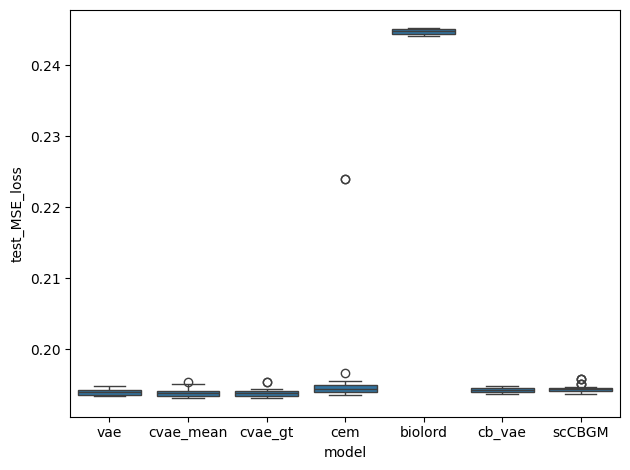

In [19]:
fig,ax = plt.subplots(1,1,)
sns.boxplot(sub_df[sub_df['corruption'] == 'default'],
            x = 'model',
            y = 'test_MSE_loss',
            ax = ax)
fig.tight_layout()

Plot AVG_ACC

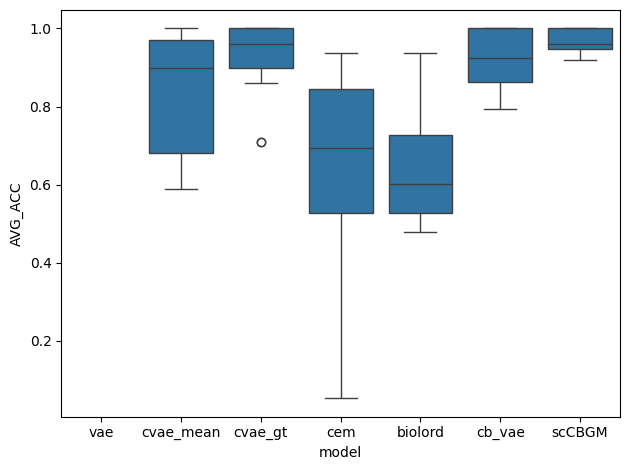

In [90]:
fig,ax = plt.subplots(1,1,)
sns.boxplot(sub_df[sub_df['corruption'] == 'default'],
            x = 'model',
            y = 'AVG_ACC',
            ax = ax)
fig.tight_layout()

Split MSE results by corruption type

<Axes: xlabel='model', ylabel='test_MSE_loss'>

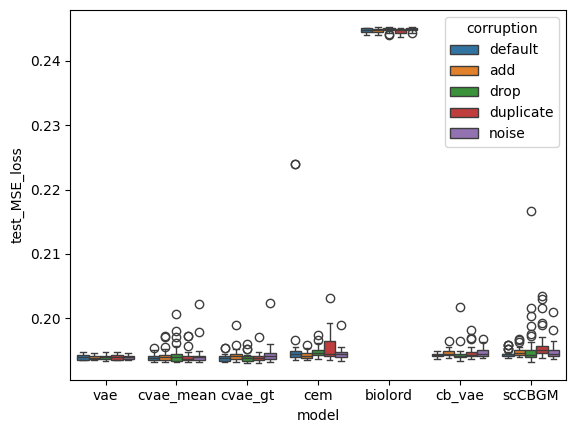

In [27]:
sns.boxplot(sub_df, x = 'model', y = 'test_MSE_loss', hue = 'corruption')

Split AVG_ACC results by corruption type

<Axes: xlabel='model', ylabel='AVG_ACC'>

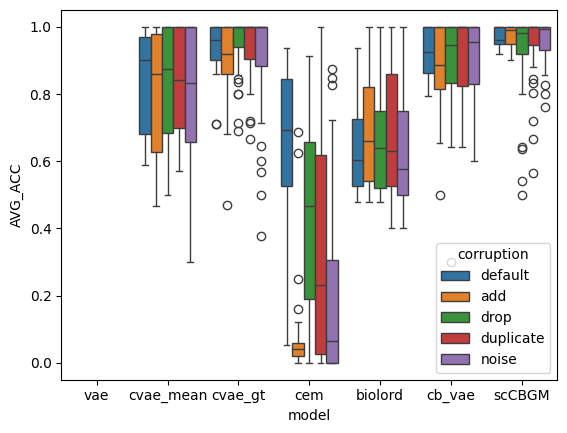

In [95]:
sns.boxplot(sub_df, x = 'model', y = 'AVG_ACC', hue = 'corruption')

Generate tables for paper

In [23]:
pretty_results = []
for k,values in enumerate(['test_MSE_loss', 'AVG_ACC']):
    mean_vals = sub_df.groupby(['model','corruption'], as_index=False).agg('mean').pivot(index='corruption', columns = 'model', values = values)
    std_vals = sub_df.groupby(['model','corruption'], as_index=False).agg('std').pivot(index='corruption', columns = 'model', values = values)
    pretty_res = mean_vals.round(3).astype(str) + r'$\pm$'  + std_vals.round(3).astype('str') 
    
    if values == 'AVG_ACC':
        pretty_res.drop(columns=['vae'], inplace=True)
        for row,col in  mean_vals.idxmax(axis=1).items():
            max_value = pretty_res.at[row,col]
            pretty_res.at[row,col] = '\\textbf{' + str(max_value) + '}'
        
        
    pretty_res.index.name = None
    pretty_res.columns.name = None
    pretty_results.append(pretty_res.copy())
    
    
    print(f'\n======= Table {k+1} ======\n')
    
    pretty_res.columns = pretty_res.columns.map({'vae' : "VAE",
                                                'cvae_mean':'CVAE\\textsubscript{mean}',
                                                'cvae_gt' : 'CVAE\\textsubscript{GT}',
                                                 'cem': 'CEM',
                                                 'biolord' : 'biolord',
                                                'cb_vae':'CB-VAE',
                                                 'scCBGM' : 'scCBGM',
                                                })
    
    pretty_res.index = pretty_res.index.map({'add':'Add',
                                             'noise':'Noise',
                                             'drop':'Drop',
                                             'duplicate':'Duplicate',
                                             'default':'None',
                                            })

    
    
    print(pretty_res.to_latex())


======= Table 1 ======

\begin{tabular}{llllllll}
\toprule
 & VAE & CVAE\textsubscript{mean} & CVAE\textsubscript{GT} & CEM & biolord & CB-VAE & scCBGM \\
\midrule
None & 0.194$\pm$0.0 & 0.194$\pm$0.001 & 0.194$\pm$0.001 & 0.196$\pm$0.006 & 0.245$\pm$0.0 & 0.194$\pm$0.0 & 0.194$\pm$0.0 \\
Add & 0.194$\pm$0.0 & 0.194$\pm$0.001 & 0.194$\pm$0.001 & 0.194$\pm$0.0 & 0.245$\pm$0.0 & 0.195$\pm$0.001 & 0.195$\pm$0.001 \\
Drop & 0.194$\pm$0.0 & 0.194$\pm$0.001 & 0.194$\pm$0.001 & 0.195$\pm$0.001 & 0.245$\pm$0.0 & 0.194$\pm$0.001 & 0.195$\pm$0.004 \\
Duplicate & 0.194$\pm$0.0 & 0.194$\pm$0.001 & 0.194$\pm$0.001 & 0.195$\pm$0.002 & 0.245$\pm$0.0 & 0.195$\pm$0.001 & 0.196$\pm$0.002 \\
Noise & 0.194$\pm$0.0 & 0.194$\pm$0.001 & 0.194$\pm$0.001 & 0.194$\pm$0.001 & 0.245$\pm$0.0 & 0.195$\pm$0.001 & 0.195$\pm$0.001 \\
\bottomrule
\end{tabular}


======= Table 2 ======

\begin{tabular}{lllllll}
\toprule
 & CVAE\textsubscript{mean} & CVAE\textsubscript{GT} & CEM & biolord & CB-VAE & scCBGM \\
\midrule
N

/tmp/ipykernel_780982/1924909280.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_vals = sub_df.groupby(['model','corruption'], as_index=False).agg('mean').pivot(index='corruption', columns = 'model', values = values)
/tmp/ipykernel_780982/1924909280.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_vals = sub_df.groupby(['model','corruption'], as_index=False).agg('std').pivot(index='corruption', columns = 'model', values = values)
/tmp/ipykernel_780982/1924909280.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obse

In [30]:
print('test_MSE_loss:')
pretty_results[0]

test_MSE_loss


,vae,cvae_mean,cvae_gt,cem,biolord,cb_vae,scCBGM
default,0.194$\pm$0.0,0.194$\pm$0.001,0.194$\pm$0.001,0.196$\pm$0.006,0.245$\pm$0.0,0.194$\pm$0.0,0.194$\pm$0.0
add,0.194$\pm$0.0,0.194$\pm$0.001,0.194$\pm$0.001,0.194$\pm$0.0,0.245$\pm$0.0,0.195$\pm$0.001,0.195$\pm$0.001
drop,0.194$\pm$0.0,0.194$\pm$0.001,0.194$\pm$0.001,0.195$\pm$0.001,0.245$\pm$0.0,0.194$\pm$0.001,0.195$\pm$0.004
duplicate,0.194$\pm$0.0,0.194$\pm$0.001,0.194$\pm$0.001,0.195$\pm$0.002,0.245$\pm$0.0,0.195$\pm$0.001,0.196$\pm$0.002
noise,0.194$\pm$0.0,0.194$\pm$0.001,0.194$\pm$0.001,0.194$\pm$0.001,0.245$\pm$0.0,0.195$\pm$0.001,0.195$\pm$0.001


In [31]:
print('AVG_ACC:')
pretty_results[1]

AVG_ACC


,cvae_mean,cvae_gt,cem,biolord,cb_vae,scCBGM
default,0.828$\pm$0.145,0.939$\pm$0.071,0.639$\pm$0.254,0.636$\pm$0.136,0.919$\pm$0.082,\textbf{0.969$\pm$0.03}
add,0.794$\pm$0.185,0.903$\pm$0.11,0.069$\pm$0.131,0.68$\pm$0.162,0.887$\pm$0.124,\textbf{0.974$\pm$0.031}
drop,0.831$\pm$0.156,\textbf{0.956$\pm$0.08},0.424$\pm$0.28,0.674$\pm$0.168,0.901$\pm$0.131,0.931$\pm$0.118
duplicate,0.83$\pm$0.155,0.938$\pm$0.087,0.347$\pm$0.332,0.685$\pm$0.18,0.911$\pm$0.107,\textbf{0.951$\pm$0.094}
noise,0.805$\pm$0.188,0.906$\pm$0.158,0.205$\pm$0.265,0.632$\pm$0.166,0.9$\pm$0.113,\textbf{0.96$\pm$0.057}
